# OpenPIV examples that you can execute in your browser

Thanks to the great service of mybinder.org

## Import what is necessary from OpenPIV

In [1]:
from openpiv import tools, validation, filters, scaling, pyprocess
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from ipywidgets import interact_manual, interactive, fixed, IntSlider, HBox, VBox, Layout

## Read a pair of PIV images

In [2]:
frame_a  = tools.imread( 'exp1_001_b.bmp' )
frame_b  = tools.imread( 'exp1_001_c.bmp' )

## Show them using matplotlib

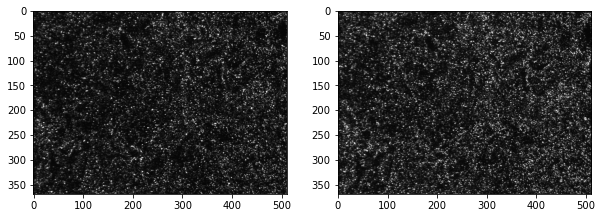

In [3]:
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)


## Define the PIV analysis parameters

1. Size of the interrogation window in frame A (winsize), 
2. Size of the search window in frame B (searchsize is larger or equal to winsize), 
3. overlap between the neighbouring windows (overlap), 
4. time interval of the PIV recording ($\Delta t$)
5. type of the peak quality (signal-to-noise ratio)

In [4]:
winsize = 32 # pixels, interrogation window size in frame A
searchsize = 38  # pixels, search in image B
overlap = 12 # pixels, 50% overlap
dt = 0.02 # sec, time interval between pulses


## Run the OpenPIV (fast code, precompiled in Cython)

In [5]:
u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')

## Get a list of coordinates for the vector field

In [6]:
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )

## Clean the peaks that are below a quality threshold

In [7]:
u1, v1, mask = validation.sig2noise_val( u0, v0, 
                                        sig2noise, 
                                        threshold = 1.05 )
# if you need more detailed look, first create a histogram of sig2noise
# plt.hist(sig2noise.flatten())
# to see where is a reasonable limit

## Replace those that are masked as bad vectors with local interpolation

In [8]:
# filter out outliers that are very different from the
# neighbours

u2, v2 = filters.replace_outliers( u1, v1, 
                                  method='localmean', 
                                  max_iter=3, 
                                  kernel_size=3)

## Scale the results from pix/dt to mm/sec

In [9]:
# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(x, y, u2, v2, 
                               scaling_factor = 96.52 ) # 96.52 microns/pixel

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

## store the result in a text file

In [10]:
# save in the simple ASCII table format
tools.save(x, y, u3, v3, mask, 'exp1_001.txt' )

## plot the data stored in the text file

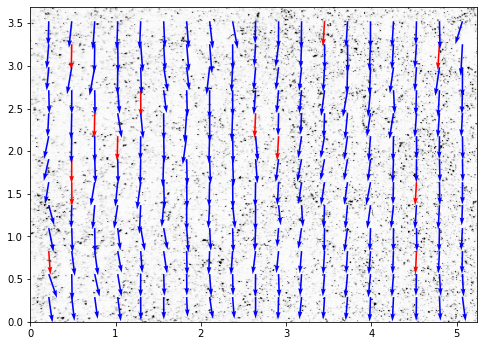

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field('exp1_001.txt', 
                           ax=ax, scaling_factor=96.52, 
                           scale=50, # scale defines here the arrow length
                           width=0.0035, # width is the thickness of the arrow
                           on_img=True, # overlay on the image
                           image_name='exp1_001_b.bmp');

# Another example
## Use any pair of images that you can access via URL
For instance we can use images from PIV Challenge http://www.pivchallenge.org/

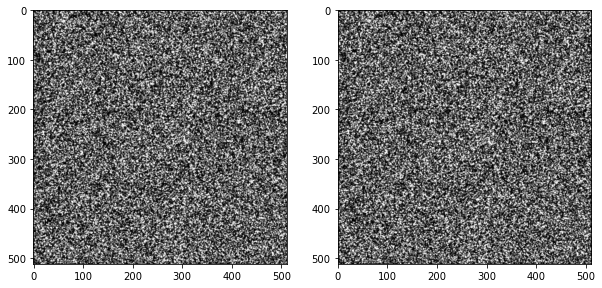

In [12]:
frame_a = tools.imread('http://www.pivchallenge.org/pub/B/B001_1.tif')
frame_b = tools.imread('http://www.pivchallenge.org/pub/B/B001_2.tif')
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

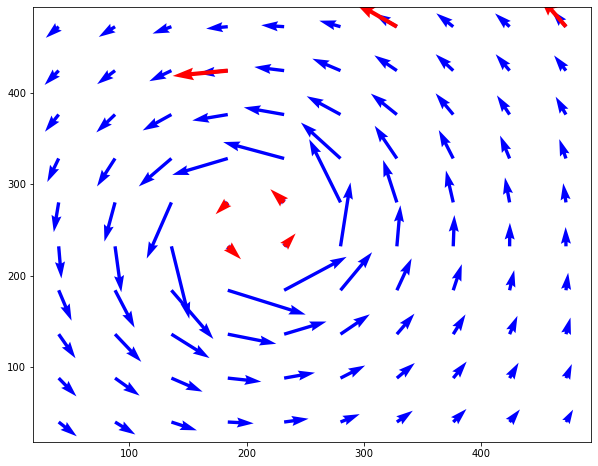

In [13]:
winsize = 32 # pixels
searchsize = 64  # pixels, search in image B
overlap = 16 # pixels
dt = 1.0 # sec
u0, v0, sig2noise = pyprocess.extended_search_area_piv( frame_a.astype(np.int32), frame_b.astype(np.int32), window_size=winsize, overlap=overlap, dt=dt, search_area_size=searchsize, sig2noise_method='peak2peak' )
x, y = pyprocess.get_coordinates( image_size=frame_a.shape,search_area_size=searchsize, overlap=overlap )
u, v, mask = validation.sig2noise_val( u0, v0, sig2noise, threshold = 1.1 )
u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
# x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 96.52 )

plt.figure(figsize=(10,8))
plt.quiver(x,y,u,v,color='b')
plt.quiver(x[mask],y[mask],u[mask],v[mask],color='r')

# How to use IpyWidgets to get an interactive GUI
## Import ipywidgets 
read more about those on https://ipywidgets.readthedocs.io/en/stable/index.html

In [14]:
from ipywidgets import interact, interactive, fixed, interact_manual

In [15]:
def func(winsize,overlap,searchsize,s2n_method,s2n_threshold):
    if overlap >= winsize:
        overlap -= 1
        
    u, v, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), frame_b.astype(np.int32), window_size=winsize, overlap=overlap, dt=dt, search_area_size=searchsize, sig2noise_method=s2n_method )
    x, y = pyprocess.get_coordinates( image_size=frame_a.shape, search_area_size=searchsize, overlap=overlap )
    u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = s2n_threshold )
    u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
    plt.figure(figsize=(10,8))
    plt.quiver(x,y,u,v,color='b')
    plt.quiver(x[mask],y[mask],u[mask],v[mask],color='r');

## Press Run interact to get PIV output for the values in the list 

In [16]:
def run():
    interact_manual(func,winsize=[32,8,16,64,128],
                overlap=[16,8,32,64], 
                searchsize=[64,16,32,128,256],
                s2n_method=['peak2peak','peak2mean'],
                s2n_threshold=(1.0,1.5,.05));

In [17]:
run()

interactive(children=(Dropdown(description='winsize', options=(32, 8, 16, 64, 128), value=32), Dropdown(descri…

## Let's say you want this GIF motion from the excellent JPIV website 

In [20]:
from IPython.display import Image
Image(url='https://eguvep.github.io/jpiv/fig/bode.gif')

In [52]:
# read it:
import imageio
gif = imageio.get_reader('https://eguvep.github.io/jpiv/fig/bode.gif')

In [55]:
frames = []
for frame in gif:
    frames.append(frame)

In [56]:
# convert to gray scale
from skimage import img_as_uint
# frame_a = img_as_uint(gif[0])
# frame_b = img_as_uint(gif[1])

frame_a = frames[0][:,:,2]
frame_b = frames[1][:,:,2]

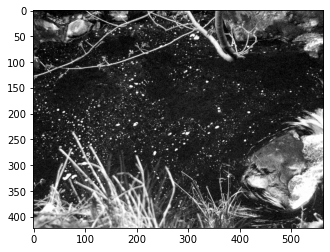

In [57]:
# see if this is what you want
plt.figure()
plt.imshow(frame_a,cmap=plt.cm.gray)

In [60]:
def run():
    interact_manual(func,winsize=[32,8,16,64,128],
                overlap=[16,8,32,64], 
                searchsize=[64,16,32,128,256],
                s2n_method=['peak2peak','peak2mean'],
                s2n_threshold=(1.0,1.5,.05));

In [61]:
run()

interactive(children=(Dropdown(description='winsize', options=(32, 8, 16, 64, 128), value=32), Dropdown(descri…